# DATA601

Joshua Black

## Exploring rel subset with text analytics

The philosophy subset is the collection of all documents in the corpus containing matches with the regex pattern 'philoso*'. 

This document will use concordancing, collocation, and cooccurance to develop a sense of how the word 'philosophy' appears in the corpus and to pick out other related terms which may be useful for picking out philosophical writing from the corpus.

In [1]:
#Imports
from __future__ import print_function

import sys
import os
import glob
import re
import logging
from random import sample

import pandas as pd
import numpy as np
import networkx as nx

from gensim import corpora
from gensim.models import LdaMulticore, TfidfModel
from gensim.matutils import corpus2csc

from nltk.text import Text
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords, words

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import NL_helpers
import NL_topicmodels # Will need to generate BOW using function in topic models.

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

TOKENIZER = RegexpTokenizer(r"[A-Za-z']+")
STOPWORDS = set(stopwords.words('english'))
WORDS = set(words.words()) 

In [ ]:
# Run cell to reload NL_helpers and NL_topicmodels if they have been changed.
from importlib import reload
reload(NL_helpers)
reload(NL_topicmodels)

### Loading Dataset

I have already generated a dataset containing all articles with the regex search term 'philoso*' run on the NL library. I load it as follows:

**Note, error:** the step at which I apply the search is before the text has been converted to lower case. The results of the re search are case sensitive. I had intended to include, e.g. 'Philosophy' as well. I don't expect that this will cause too many problems. 

In [2]:
philoso_df = pd.read_pickle('pickles/rel_v2_philoso_df.tar.gz')

In [5]:
philoso_df['Tokenised'] = philoso_df['Text'].apply(
    lambda x: TOKENIZER.tokenize(' '.join(x).lower())
)

In [ ]:
# Duplicates ought to be removed from 'subset' corpus, but have already been removed from full 'philoso*' corpus.
# philoso_df = philoso_df[~philoso_df.astype(str).duplicated()]

In [6]:
# Counts by newspaper
philoso_df.index.map(lambda x: x[0:x.find('_')]).value_counts()

ODT        1163
ESD        1064
AS          879
OW          869
CHP         558
LT          467
NZTIM       425
BH          391
TC          344
HBH         320
NEM         298
WC          263
WH          242
DSC         234
NOT         226
OAM         221
DTN         211
MEX         158
WCT         138
WT          124
GRA         119
WSTAR       116
AG          110
CROMARG      90
LWM          89
MIC          85
WI           75
ME           75
FS           73
DUNST        58
WDT          53
WAIST        48
MT           38
MS           38
OO           37
WEST         32
WOODEX       31
IT           30
LCP          30
MH           30
HNS          28
BA           26
NA           21
CL           20
HBT          18
KUMAT        14
OG            8
HAST          7
OPUNT         7
NZSCSG        4
HLC           3
NZCPNA        1
HBWT          1
WDA           1
MTBM          1
ALG           1
dtype: int64

The above output shows that we have 29575 items containing 'philoso\*' in the whole dataset. This is between two and three times the size of the 'starter corpus', but is significantly smaller than the total corpus. **TODO: put full size here.**

I've also produced a count for each newspaper. OW - the Otago Witness tops the list. Surprising as this was a weekly paper and so should be expected to have less total issues than the others. However, it might have had more 'intellectual' content 

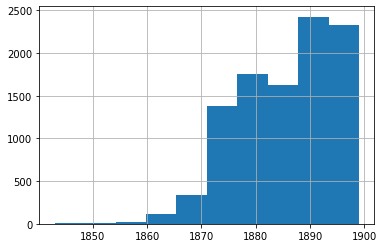

In [7]:
# Counts by year.
philoso_df.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

### Basic Exploration

#### Inspecting a subset of the corpus

We can look at a random subset of the corpus as follows:

In [ ]:
sample_indices = sample(list(philoso_df.index), 100)
interact(NL_helpers.html_text, index=sample_indices, dataframe=fixed(philoso_df), boldface=fixed('philoso*\\w*'))

A few notes: * (Note your random sample will be different)
 - AS_18860821_ARTICLE40: Example of argument with 'freethinker' over grouding ethics(?) in 'natural right' vs Christian approach. Interesting as lower limit in terms of OCR quality?
 - Use of 'philosophical' to mean deep, resigned, detatched.
 - 'philosophers and sceptics' vs Christians.
 - CHP_18980425_ARTICLE60: Report of what is issued at the wellington public library in 1898 - 'philosophical subjects are almost entire;y neglected'
 - Discussion of Darwinism as new philosophy.
 - Discussions of e.g. Stoicism.
 - 1893 Hosking on Miricles, listed as 'popular lecture'. CHP_18930515_ARTICLE22
 - **In general, quite a few reprints of exerpts from texts. (e.g. BH_18890222_ARTICLE33)
 - Robert Stout comes up a lot as an early political figure who is thought of as having, e.g. 'a philosophic mind'.
 - Some lecture reports coming through (e.g. AS_18800817_ARTICLE22, CHP_18690823_ARTICLE15)
 - Theosophy coming through
 - Quite a lot of extracts of fiction (one with a Hegelian character).
 - CL_18790919_ARTICLE27 - first-order philosophy - including definition of 'philosophy' in Clutha Leader.
 - CHP_18920926_ARTICLE10 - good letters to editor on 'freethought' and christianity
 

#### Concordancing

We begin by quickly looking through concordances for key words. The initial 'flat list' of tokens is taken from a random sample of 1000 items in the corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised'].sample(n=1000, random_state=1):
    for token in tokens:
        flat_list.append(token)
sample_text = Text(flat_list)
del flat_list

This notebook keeps the full dataset in memory. I'll be using 'del' to remove references to large objects.

First up, 'philosophy':

In [ ]:
sample_text.concordance('philosophy', width=100, lines=150)

Notable:
 - discussion of 'natural philosophy' and 'experimental philosophy' - what would today be called 'science'.
 - generic use of 'philosophy' as 'way of thinking'
 - philosophy as 'extravagant theories'
 - Quite a few descriptions of people 'aquire his graveful pedantry his philosophy his ripe wisdom' which sound like descriptions in a Victorian novel... There is quite a bit of serialised fiction in the general corpus.
 - some discussion of academic situations (classrooms etc)
  - mention of particular philosophers both ancient and contemp (Plato, the stoics, Descartes, Spencer, Carlyle)
  - Ambiguous relationship with theology. 
  - NZ figures: e.g. Robert Stout

In [ ]:
sample_text.concordance('lecture', width=100, lines=150)

In [ ]:
del sample_text

#### Collocations

Collocations shows which words have a tendency to appear together *near one another* in documents (cf. co-occurrence). The ranking of word pairs depends on the statistic chosen.

**PMI:** pointwise mutual information is a measure from information theory. Suppose we have probability distributions for each word, *x* and *y*, we might wonder how much information about p(x) is carried by p(y). If the words *x* and *y* always occur together, then *pmi* will be very high. This makes PMI a good measure of word occurence (dreadful - come back once you've reminded yourself how this works).

**Likelihood ratio:**

The code below collects all immediate bigrams for a window of size 2 and of size 5. We then filter our bigrams which do not contain 'philosophy', those which appear less than three times, and those which contain stopwords.

We again build up a flat list, but this time with the whole corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised']:
    for token in tokens:
        flat_list.append(token)
all_text = Text(flat_list)
del flat_list

##### Window size = 2

In [ ]:
philoso_filter = lambda *w: 'philosophy' not in w
stopword_filter = lambda w: w in STOPWORDS

In [ ]:
bcf = BigramCollocationFinder.from_words(all_text)

In [ ]:
bcf.apply_ngram_filter(philoso_filter)
bcf.apply_word_filter(stopword_filter)
bcf.apply_freq_filter(10)

In [ ]:
bm = BigramAssocMeasures()

In [ ]:
pmi_ws2 = bcf.nbest(bm.pmi, 50)
pmi_ws2

With a window size of two, we get words either side of 'philosophy'.
Notes:
 - natural comes up again, along with 'experimental', 'positive', 'inductive'. 
 - 'pig philosophy' is, I think, a term of Carylye's - suggest some specific discussions.
 - most suggest intellectual discussion (except maybe 'proverbial'.

In [ ]:
lr_ws2 = bcf.nbest(bm.likelihood_ratio, 50)
lr_ws2

In [ ]:
pmi_not_lr = []
for collocation in pmi_ws2:
    if collocation not in lr_ws2:
        pmi_not_lr.append(collocation)
pmi_not_lr

In [ ]:
lr_not_pmi = []
for collocation in lr_ws2:
    if collocation not in pmi_ws2:
        lr_not_pmi.append(collocation)
lr_not_pmi

The differences here don't seem to make a big difference to the conclusions above. Not surprising as they are very closely related measures.

In [ ]:
del bcf
del all_text

##### Window size = 5

We can also expand the window to consider words either five spaces to the left or right of philosophy. (Window size includes stopwords)

In [ ]:
bcf_big = BigramCollocationFinder.from_words(all_text, window_size=5)

In [ ]:
bcf_big.apply_ngram_filter(philoso_filter)
bcf_big.apply_word_filter(stopword_filter)
bcf_big.apply_freq_filter(10)

In [ ]:
pmi_ws5 = bcf_big.nbest(bm.pmi, 50)
pmi_ws5

The general impression of these collocations is quite similar to those with window size two. 
Notes:
 - I've noticed 'there are more things in heaven and earth than dreamt ...' a few times while looking through the corpus. I supsect ('dreamt', 'philosophy') comes from this.
 - There's more evidence of 'natural philosophy' etc. We also get 'mental philosophy' something like psychology.
 - Discussion of Herbert Spencer coming through also.
 - In general: evidence of intellectual content.

In [ ]:
lr_ws5 = bcf_big.nbest(bm.likelihood_ratio, 50)
lr_ws5

In [ ]:
pmi_not_lr_ws5 = []
for collocation in pmi_ws5:
    if collocation not in lr_ws5:
        pmi_not_lr_ws5.append(collocation)
pmi_not_lr_ws5

In [ ]:
lr_not_pmi_ws5 = []
for collocation in lr_ws5:
    if collocation not in pmi_ws5:
        lr_not_pmi_ws5.append(collocation)
lr_not_pmi_ws5

More difference in results here (more ngrams to choose between). But neither list gives a particularly different impression of the corpus as a whole.

In [ ]:
len(lr_not_pmi_ws5)

In [ ]:
del bcf_big, all_text

Differences in scoring more pronounced.

#### Co-occurence

To perform document-level cooccurence analysis we will shift from NLTK to gensim. We first build a dictionary.

In [9]:
minimum_in_docs = 10 # 10
max_prop = 0.5
dictionary = corpora.Dictionary(philoso_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2021-01-25 10:58:03,524 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-25 10:58:09,882 : INFO : adding document #10000 to Dictionary(257722 unique tokens: ["'", 'a', 'aa', 'about', 'above']...)
2021-01-25 10:58:09,998 : INFO : built Dictionary(262787 unique tokens: ["'", 'a', 'aa', 'about', 'above']...) from 10146 documents (total 7718025 corpus positions)
2021-01-25 10:58:10,338 : INFO : discarding 239685 tokens: [("'", 5711), ('a', 10043), ('agerf', 1), ('all', 7956), ('amoebae', 2), ('an', 7713), ('and', 10115), ('any', 5746), ('archmopteryx', 1), ('are', 7487)]...
2021-01-25 10:58:10,338 : INFO : keeping 23102 tokens which were in no less than 10 and no more than 5073 (=50.0%) documents
2021-01-25 10:58:10,419 : INFO : resulting dictionary: Dictionary(23102 unique tokens: ['aa', 'about', 'above', 'accomplished', 'accordingly']...)


In [11]:
dictionary.save(f'dictionaries/rel_v2_df_min{minimum_in_docs}_max{int(max_prop*100)}perc.dict')

2021-01-27 09:59:43,736 : INFO : saving Dictionary object under dictionaries/rel_v2_df_min10_max10perc.dict, separately None
2021-01-27 09:59:43,742 : INFO : saved dictionaries/rel_v2_df_min10_max10perc.dict


This dictionary is much too large for our purposes (at ~70k words). We can filter stop words and all one and two letter words from the tokenized text to see what happens.

In [9]:
philoso_df['Tokenised'] = philoso_df['Tokenised'].map(lambda x: [word for word in x if len(word)>2 and not word in STOPWORDS and word in WORDS])

In [10]:
minimum_in_docs = 10 # reduced to 10 from 50 as corpus has got much smaller.
max_prop = 0.1
dictionary = corpora.Dictionary(philoso_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2021-01-27 09:59:18,143 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-27 09:59:20,810 : INFO : adding document #10000 to Dictionary(29041 unique tokens: ['accomplished', 'accordingly', 'account', 'act', 'actual']...)
2021-01-27 09:59:20,815 : INFO : built Dictionary(29053 unique tokens: ['accomplished', 'accordingly', 'account', 'act', 'actual']...) from 10013 documents (total 2529106 corpus positions)
2021-01-27 09:59:20,893 : INFO : discarding 17460 tokens: [('account', 1348), ('although', 1257), ('amoebae', 2), ('another', 2757), ('anything', 1545), ('appear', 1134), ('away', 1801), ('believe', 2943), ('came', 1551), ('cannot', 2974)]...
2021-01-27 09:59:20,894 : INFO : keeping 11593 tokens which were in no less than 10 and no more than 1001 (=10.0%) documents
2021-01-27 09:59:20,911 : INFO : resulting dictionary: Dictionary(11593 unique tokens: ['accomplished', 'accordingly', 'act', 'actual', 'ail']...)


In [12]:
rel_corpus = NL_topicmodels.NL_corpus(philoso_df, dictionary)

In [14]:
tfidf_model = TfidfModel(rel_corpus, dictionary=rel_corpus.dictionary)

2021-01-27 10:00:26,952 : WARNING : constructor received both corpus and explicit inverse document frequencies; ignoring the corpus


In [15]:
rel_corpus.items

,Title,Text,Newspaper,Date,Text as String,Religion (pred),Tokenised,BOW
LT_18940109_ARTICLE7,THE TASK OF THE BIOLOGIST.,[No. 11. When chemistry had finished _ shaping...,LT,18940109,No. 11. When chemistry had finished _ shaping;...,True,"[chemistry, finished, shaping, stuff, physical...","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1..."
LT_18940115_ARTICLE5,THE THEORY OF EVOLUTION.,[SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' ...,LT,18940115,SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' '...,True,"[significant, consideration, various, evidence...","[(1, 1), (7, 2), (17, 1), (24, 1), (31, 1), (3..."
LT_18940129_ARTICLE48,THE THEORY OF EVOLUTION.,[A CHANGED WORLD. [BY W.G.P.] No. V. The bitte...,LT,18940129,A CHANGED WORLD. [BY W.G.P.] No. V. The bitter...,True,"[world, bitter, controversy, rang, round, orig...","[(3, 1), (4, 1), (6, 1), (12, 1), (18, 1), (23..."
LT_18940219_ARTICLE18,HERESY.,"[TO THE EDITOR. Sir,— The action of the Presby...",LT,18940219,"TO THE EDITOR. Sir,— The action of the Presbyt...",True,"[editor, sir, action, assembly, rev, exercise,...","[(70, 1), (84, 2), (96, 2), (342, 1), (391, 1)..."
LT_18940219_ARTICLE24,REV JAMES GIBB ON CHRISTIAN DUTY.,"[At St Andrew’s Presbyterian Church, yesterday...",LT,18940219,"At St Andrew’s Presbyterian Church, yesterday ...",True,"[church, yesterday, forenoon, rev, one, church...","[(69, 1), (70, 1), (83, 1), (84, 2), (85, 1), ..."
...,...,...,...,...,...,...,...,...
ODT_18771031_ARTICLE30,THE INDIAN FAMINE.,[TO THE TJDITOR. Sir—l think I have_ fair caus...,ODT,18771031,TO THE TJDITOR. Sir—l think I have_ fair cause...,True,"[sir, think, fair, cause, complaint, matter, d...","[(21, 1), (53, 1), (147, 1), (274, 1), (276, 1..."
ODT_18771107_ARTICLE32,POPULAR CULTURE.,"[The. discourse of Mi* J^hn M >r!ev on "" I'opu...",ODT,18771107,"The. discourse of Mi* J^hn M >r!ev on "" I'opul...",True,"[discourse, urn, special, pro, method, cation,...","[(76, 1), (208, 1), (245, 1), (332, 1), (348, ..."
ODT_18790115_ARTICLE20,MR BRIGHT AND THE ELDERS. TO THE EDITOR.,"[Sib,—However objectionable Mr Bright's title ...",ODT,18790115,"Sib,—However objectionable Mr Bright's title m...",True,"[sib, however, objectionable, title, may, subs...","[(59, 1), (125, 1), (221, 1), (369, 1), (469, ..."
ODT_18790118_ARTICLE23,UNTITLED,"[Sir,—Before the public can fairly under stand...",ODT,18790118,"Sir,—Before the public can fairly under stand ...",True,"[sir, public, fairly, stand, position, taken, ...","[(27, 1), (49, 1), (50, 1), (81, 1), (116, 1),..."


In [17]:
rel_corpus.items['TF-IDF'] = tfidf_model[rel_corpus]

In [18]:
rel_corpus.items

,Title,Text,Newspaper,Date,Text as String,Religion (pred),Tokenised,BOW,TF-IDF
LT_18940109_ARTICLE7,THE TASK OF THE BIOLOGIST.,[No. 11. When chemistry had finished _ shaping...,LT,18940109,No. 11. When chemistry had finished _ shaping;...,True,"[chemistry, finished, shaping, stuff, physical...","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1...","[(0, 0.037070735571766454), (1, 0.041171491974..."
LT_18940115_ARTICLE5,THE THEORY OF EVOLUTION.,[SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' ...,LT,18940115,SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' '...,True,"[significant, consideration, various, evidence...","[(1, 1), (7, 2), (17, 1), (24, 1), (31, 1), (3...","[(1, 0.03877920363299661), (7, 0.0474379255522..."
LT_18940129_ARTICLE48,THE THEORY OF EVOLUTION.,[A CHANGED WORLD. [BY W.G.P.] No. V. The bitte...,LT,18940129,A CHANGED WORLD. [BY W.G.P.] No. V. The bitter...,True,"[world, bitter, controversy, rang, round, orig...","[(3, 1), (4, 1), (6, 1), (12, 1), (18, 1), (23...","[(3, 0.039525783600009204), (4, 0.043022224916..."
LT_18940219_ARTICLE18,HERESY.,"[TO THE EDITOR. Sir,— The action of the Presby...",LT,18940219,"TO THE EDITOR. Sir,— The action of the Presbyt...",True,"[editor, sir, action, assembly, rev, exercise,...","[(70, 1), (84, 2), (96, 2), (342, 1), (391, 1)...","[(70, 0.06050284829925989), (84, 0.12139272470..."
LT_18940219_ARTICLE24,REV JAMES GIBB ON CHRISTIAN DUTY.,"[At St Andrew’s Presbyterian Church, yesterday...",LT,18940219,"At St Andrew’s Presbyterian Church, yesterday ...",True,"[church, yesterday, forenoon, rev, one, church...","[(69, 1), (70, 1), (83, 1), (84, 2), (85, 1), ...","[(69, 0.04511879612777872), (70, 0.05041281137..."
...,...,...,...,...,...,...,...,...,...
ODT_18771031_ARTICLE30,THE INDIAN FAMINE.,[TO THE TJDITOR. Sir—l think I have_ fair caus...,ODT,18771031,TO THE TJDITOR. Sir—l think I have_ fair cause...,True,"[sir, think, fair, cause, complaint, matter, d...","[(21, 1), (53, 1), (147, 1), (274, 1), (276, 1...","[(21, 0.07691984333370662), (53, 0.07667630373..."
ODT_18771107_ARTICLE32,POPULAR CULTURE.,"[The. discourse of Mi* J^hn M >r!ev on "" I'opu...",ODT,18771107,"The. discourse of Mi* J^hn M >r!ev on "" I'opul...",True,"[discourse, urn, special, pro, method, cation,...","[(76, 1), (208, 1), (245, 1), (332, 1), (348, ...","[(76, 0.08702171966396995), (208, 0.1061276437..."
ODT_18790115_ARTICLE20,MR BRIGHT AND THE ELDERS. TO THE EDITOR.,"[Sib,—However objectionable Mr Bright's title ...",ODT,18790115,"Sib,—However objectionable Mr Bright's title m...",True,"[sib, however, objectionable, title, may, subs...","[(59, 1), (125, 1), (221, 1), (369, 1), (469, ...","[(59, 0.13881791195587193), (125, 0.0952330491..."
ODT_18790118_ARTICLE23,UNTITLED,"[Sir,—Before the public can fairly under stand...",ODT,18790118,"Sir,—Before the public can fairly under stand ...",True,"[sir, public, fairly, stand, position, taken, ...","[(27, 1), (49, 1), (50, 1), (81, 1), (116, 1),...","[(27, 0.10105029797602266), (49, 0.07671554843..."


In [19]:
rel_corpus.items.to_pickle('pickles/rel_v2_df_with_bow_and_tfidf.pickle')

Changes over time? - I don't think this is helping me. Need some more non-philosophy as a background.

In [30]:
sparse = corpus2csc(rel_corpus.items['BOW'])

In [31]:
dtm = pd.DataFrame.sparse.from_spmatrix(sparse)
del sparse

In [32]:
dtm.index = rel_corpus.dictionary.values()

In [33]:
dtm

,0,1,2,3,4,5,6,7,8,9,...,10003,10004,10005,10006,10007,10008,10009,10010,10011,10012
accomplished,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accordingly,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
act,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
actual,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ail,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
judices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
geologically,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
heedless,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
referee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
dtm.to_pickle('pickles/dtm_rel_v2_BOW_11kwords.tar.gz')

In [35]:
tt_df = dtm.dot(dtm.transpose())

In [36]:
tt_df.to_pickle('pickles/ttm_rel_v2_BOW_11kwords.tar.gz')

In [37]:
tt_df

,accomplished,accordingly,act,actual,ail,alike,alive,animal,apart,appearance,...,charmingly,ordinal,cane,moio,mime,judices,geologically,heedless,referee,renown
accomplished,362.0,13.0,89.0,22.0,17.0,32.0,18.0,105.0,33.0,34.0,...,1.0,0.0,0.0,3.0,2.0,0.0,2.0,1.0,0.0,0.0
accordingly,13.0,207.0,84.0,30.0,21.0,27.0,5.0,76.0,17.0,27.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
act,89.0,84.0,2497.0,148.0,95.0,175.0,51.0,568.0,140.0,114.0,...,2.0,3.0,1.0,9.0,7.0,3.0,7.0,1.0,2.0,3.0
actual,22.0,30.0,148.0,724.0,26.0,40.0,19.0,286.0,56.0,67.0,...,2.0,0.0,0.0,0.0,7.0,2.0,4.0,0.0,0.0,0.0
ail,17.0,21.0,95.0,26.0,446.0,44.0,17.0,114.0,53.0,36.0,...,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
judices,0.0,0.0,3.0,2.0,0.0,1.0,2.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0
geologically,2.0,0.0,7.0,4.0,1.0,3.0,3.0,40.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0
heedless,1.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
referee,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0


In [ ]:
# See https://tm4ss.github.io/docs/Tutorial_5_Co-occurrence.html
def dice_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with dice statistics given search term
    document-term matrix and term-term matrix. Return as 
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    #num_documents = len(dtm.columns)
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)
    dicesig = dicesig.sort_values(ascending=False)[0:num_coocs]
    return dicesig

In [ ]:
dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)

In [ ]:
type(dicesig)

In [ ]:
dicesig.sort_values(ascending=False)[0:15]

In [ ]:
dice_coocs('philosophy', binary_dtm, tt_df, 20)

In [ ]:
NL_helpers.log_dice_coocs('infinite', dtm, tt_df, 20)

In [ ]:
philo_cooc = dice_coocs('philosophy', binary_dtm, tt_df, 10)

In [ ]:
philo_network = NL_helpers.network_dataframe(
    term='philosophy', 
    stat='ml', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=10
)

In [ ]:
philo_network_df = pd.DataFrame(data=philo_network)

In [ ]:
network = {}
for item in philo_cooc.iteritems():
    from_list = network.get('source', [])
    from_list.append('philosophy')
    network['source'] = from_list
    to_list = network.get('target', [])
    to_list.append(item[0])
    network['target'] = to_list
    weight_list = network.get('weight', [])
    weight_list.append(item[1])
    network['weight'] = weight_list
    
    item_coocs = dice_coocs(item[0], binary_dtm, tt_df, 10)
    for sub_item in item_coocs.iteritems():
        if item[0] != sub_item[0]:
            from_list = network.get('source', [])
            from_list.append(item[0])
            network['source'] = from_list
            to_list = network.get('target', [])
            to_list.append(sub_item[0])
            network['target'] = to_list
            weight_list = network.get('weight', [])
            weight_list.append(sub_item[1])
            network['weight'] = weight_list
    

In [ ]:
network_df = pd.DataFrame(data=network)

In [ ]:
network_df

In [ ]:
G = nx.convert_matrix.from_pandas_edgelist(philo_network_df, edge_attr='weight')

In [ ]:
edges = G.edges()
weights = [np.exp(G[u][v]['weight']) * 0.01 for u,v in edges]

In [ ]:
d = nx.degree(G)
sizes = [(d[node]+1) * 100 for node in G.nodes()]

In [ ]:
layout = nx.drawing.layout.spring_layout(G, k=1/np.sqrt(len(G.nodes)))

In [ ]:
len(G.nodes)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
# Visualize graph components
nx.draw_networkx_edges(G, layout, alpha=0.5, width=weights, edge_color="m")
nx.draw_networkx_nodes(G, layout, node_size=sizes, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
labels = nx.draw_networkx_labels(G, layout, font_size=11, bbox=label_options)

In [ ]:
philo_net = NL_helpers.network_dash(
    term='philosophy', 
    stat='log dice', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=25,
    sec_coocs=5
)

In [ ]:
philo_net

In [ ]:
app = JupyterDash(__name__)

philo_cytoscape = cyto.Cytoscape(
        id='philosophy-network',
        minZoom=1,
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '800px'},
        elements=philo_net,
        stylesheet=[
            {
                'selector': 'edge',
                'style': {
                    'width': 'mapData(weight, 3, 6, 1, 3)',
                    'line-color': 'silver'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'width': 'mapData(size, 1, 10, 10, 20)',
                    'height': 'mapData(size, 1, 10, 10, 20)'
                }
            },
            {
                'selector': 'label',
                'style': {
                    'font-size': 6,
                    'text-valign': 'center',
                    'text-background-color': 'white',
                    'text-background-opacity': 0.6,
                    'text-background-padding': 1,
                    'text-border-color': 'black',
                    'text-border-opacity': 1,
                    'text-border-width': 0.5
                }
            }
        ]
    )

app.layout = html.Div([
    html.H2("Cooccurence Networks (BOW)"),
    html.P("Search Term:"),
    dcc.Input(
        id='search-term',
        type='text',
        value='philosophy'
    ),
    html.P("Statistic:"),
    dcc.Dropdown(
        id='stat-choice',
        options=[
            {'label': 'Mutual likelihood', 'value': 'ml'},
            {'label': 'Log Dice', 'value': 'log dice'}
        ],
        value='ml'
    ),
    html.Button('Submit', id='submit-val', n_clicks=0),
    philo_cytoscape
])

@app.callback(
    Output(component_id='philosophy-network', component_property='elements'),
    Input(component_id='submit-val', component_property='n_clicks'),
    State(component_id='stat-choice', component_property='value'),
    State(component_id='search-term', component_property='value'),
)
def update_network_stat(n_clicks, stat_value, search_value):
    network = NL_helpers.network_dash(
        term=search_value, 
        stat=stat_value, 
        dtm=dtm,
        ttm=tt_df,
        num_coocs=10,
        sec_coocs=5
    )
    return network 

if __name__ == '__main__':
    app.run_server(debug=True, mode='inline')

#### Word Embeddings

### Next steps

#### Some candidate keywords

In [ ]:
NL_helpers.interactive_text_search(philoso_df, "[Mm]ill\'s")

In [ ]:
NL_helpers.interactive_text_search(philoso_df, '[Hh]artley')

#### Expansion of Philosophy Dataset

#### Proposed Classification Scheme

## Bonus: the topic model code again

A convenient moment for running a topic model on the philosophy corpus came up. Here is a model using the full philosophy set dictionary.

In [ ]:
len(philoso_df)

In [ ]:
starter_model = LdaMulticore(
    philo_corpus,
    num_topics= 200,
    workers = 15,
    chunksize = 220,
    id2word=philo_corpus.dictionary,
    iterations = 500,
    passes = 25,
    eval_every = 100
)

In [ ]:
dog = set(['phil'])
dog.add(1)

In [ ]:
dog = [1, 2, 3]
cat = [4, 5, 6]
dog + cat